# FoodVision has 101 food categories. 
We've had much success with FoodVision mini, it's now time to tackle the big guy.

In [1]:
import os
from pathlib import Path

import sys
sys.path.append("../")
from src.utils import get_device, plot_loss_curves
from going_modular import data_setup, engine
from going_modular.get_data import get_data
from going_modular.utils import save_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary

from tqdm.notebook import tqdm

print("PyTorch version: ",torch.__version__)
print("Torchvision version: ",torchvision.__version__)

PyTorch version:  2.0.0
Torchvision version:  0.15.2a0


## Load model and transforms
Since we're working with a large dataset, we may want to introduce data augmentation techniques. Since we are working with a large number fo classes,let's use TrivialAugment as the data augmentation technique during model training.

In [122]:
def create_effnetb2_model(num_classes: int = 3,
                          seed: int = 42):
    effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    test_transforms = effnetb2_weights.transforms()
    train_transforms = torchvision.transforms.Compose([
        torchvision.transforms.TrivialAugmentWide(),
        test_transforms])
    effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)
    for param in effnetb2.parameters():
        param.requires_grad = False
    torch.manual_seed(seed)
    effnetb2.classifier = nn.Sequential(
        nn.Dropout(p = 0.3, inplace = True),
        nn.Linear(in_features = 1408, out_features = num_classes)
    )
    return effnetb2, train_transforms, test_transforms

model, train_transforms, test_transforms = create_effnetb2_model(num_classes = 101)
summary(model, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [102]:
train_transforms, test_transforms

(Compose(
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ImageClassification(
     crop_size=[288]
     resize_size=[288]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 )
 ),
 ImageClassification(
     crop_size=[288]
     resize_size=[288]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

## Get FoodVision 101 data

In [9]:
# Setup data directory
data_dir = Path("data")

# Get training data (750 images per class for 101 classes)
train_data = datasets.Food101(root = data_dir,
                              split = "train",
                              transform = train_transforms,
                              download = True)

# Get testing data (250 images per class for 101 classes)
test_data = datasets.Food101(root = data_dir,
                             split = "test",
                             transform = test_transforms,
                             download = True)

100%|██████████| 4996278331/4996278331 [19:44<00:00, 4219134.36it/s] 


Extracting data/food-101.tar.gz to data


In [11]:
food101_class_names = train_data.classes
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Training the model on a subset of the FoodVision 101 data
We're going to aim to beat the Food101 paper's best results (56.4% test accuracy) based on just 20% of the data - because we don't have the GPU capabilities to train a fullscale model.
> Paper link: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

In [103]:
BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 
SEED = 42
LR = 1e-3
EPOCHS = 10
device = get_device()

In [45]:
def split_dataset(dataset: torchvision.datasets,
                  split_size: float = 0.2,
                  seed: int = SEED):
    """Randomly splits a dataset into 2 proportions based on split_size and seed

    Args:
        dataset (torchvision.datasets): torchvision.datasets object
        split_size (float, optional): Size of random split. Defaults to 0.2.
        seed (int, optional): Seed for reproducibility. Defaults to SEED.
    """
    l1 = int(len(dataset) * split_size)
    l2 = len(dataset) - l1
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {l1} ({int(split_size*100)}%), {l2} ({int((1-split_size)*100)}%)")
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths = [l1, l2],
                                                                   generator = torch.manual_seed(SEED))
    return random_split_1, random_split_2

In [46]:
train_data_food101_20_percent, _ = split_dataset(dataset = train_data)
test_data_food101_20_percent, _ = split_dataset(dataset = test_data)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

In [47]:
train_dataloader_food101 = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=True,
                                                       num_workers=NUM_WORKERS)
test_dataloader_food101 = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=False,
                                                      num_workers=NUM_WORKERS)

In [108]:
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
# loss_fn = torch.nn.CrossEntropyLoss(label_smoothing = 0.1) throws a `NotImplementedError: The operator 'aten::masked_scatter_' is not currently implemented for the MPS device.` 
loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model = model.to(device),
                       train_dataloader = train_dataloader_food101,
                       test_dataloader = test_dataloader_food101,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = EPOCHS,
                       device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.4702 | train_acc: 0.2762 | test_loss: 2.4381 | test_acc: 0.4875
Epoch: 2 | train_loss: 2.4979 | train_acc: 0.4351 | test_loss: 2.0153 | test_acc: 0.5371
Epoch: 3 | train_loss: 2.2187 | train_acc: 0.4821 | test_loss: 1.8394 | test_acc: 0.5607
Epoch: 4 | train_loss: 2.0594 | train_acc: 0.5064 | test_loss: 1.7645 | test_acc: 0.5707
Epoch: 5 | train_loss: 1.9834 | train_acc: 0.5181 | test_loss: 1.7126 | test_acc: 0.5738
Epoch: 6 | train_loss: 1.9104 | train_acc: 0.5320 | test_loss: 1.6753 | test_acc: 0.5850
Epoch: 7 | train_loss: 1.8527 | train_acc: 0.5427 | test_loss: 1.6414 | test_acc: 0.5862
Epoch: 8 | train_loss: 1.8178 | train_acc: 0.5549 | test_loss: 1.6323 | test_acc: 0.5866
Epoch: 9 | train_loss: 1.7792 | train_acc: 0.5552 | test_loss: 1.6080 | test_acc: 0.5938
Epoch: 10 | train_loss: 1.7530 | train_acc: 0.5618 | test_loss: 1.6287 | test_acc: 0.5869


Nice!

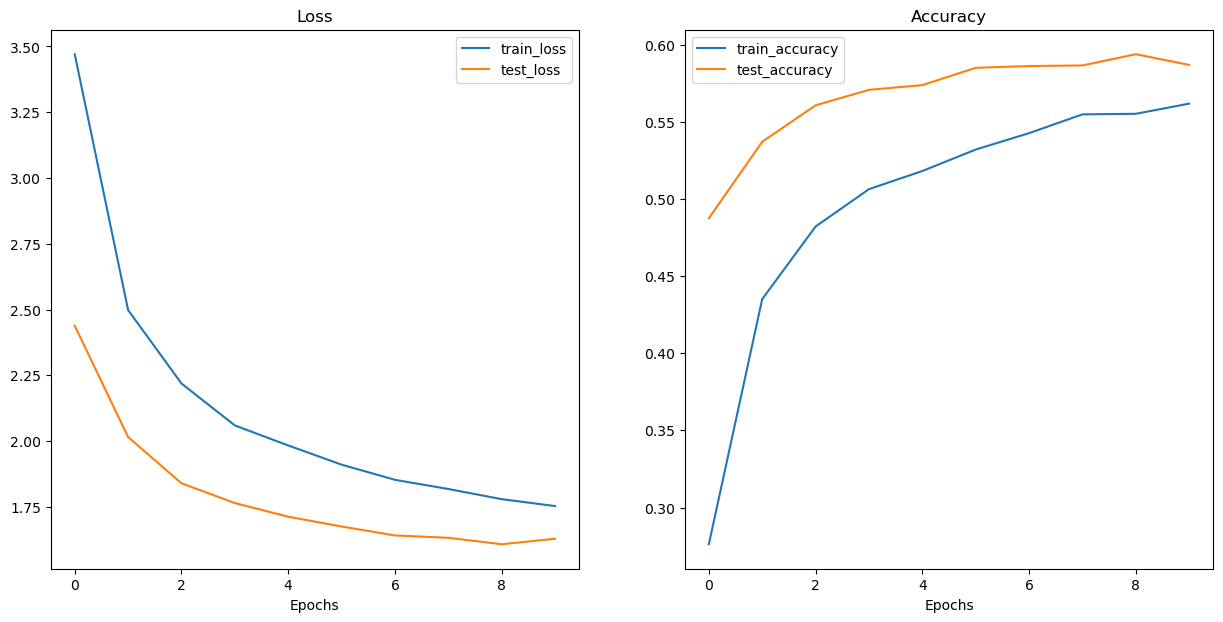

In [109]:
plot_loss_curves(results)

In [110]:
effnetb2_food101_model_path = "effnetb2_feature_extractor_food101_20_percent.pth" 

save_model(root_dir = "Models",
           model_name = effnetb2_food101_model_path,
           model = model)

Saved model to: Models/effnetb2_feature_extractor_food101_20_percent.pth


In [111]:
# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


## App development

The file directory will be:
```
deploy/
  FoodVision/
    effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```

In [112]:
%cd demos/deploy

/Users/tituslim/Documents/Personal Learning Folder/Data Science/15. PyTorch Developer Class/symmetrical-octo-spork/Notebooks/demos/deploy


In [54]:
!git clone https://huggingface.co/spaces/tituslhy/FoodVision

Cloning into 'FoodVision'...
remote: Enumerating objects: 4, done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 4
Unpacking objects: 100% (4/4), 643 bytes | 214.00 KiB/s, done.


In [98]:
foodvision_path = Path("./FoodVision")
(foodvision_path/"examples").mkdir(parents = True, 
                                   exist_ok = True)

Move sample image to examples folder

In [100]:
!mv ../../../../../../../../Desktop/sashimi.png ./FoodVision/examples/sashimi.png

Move trained model to app

In [113]:
!mv ../../Models/effnetb2_feature_extractor_food101_20_percent.pth ./FoodVision/effnetb2_feature_extractor_food101_20_percent.pth

Create class_names.txt for use in the app

In [114]:
filepath = "./FoodVision/class_names.txt"
with open(filepath, "w") as f:
    print(f"[INFO] Saving Food101 classnames to {filepath}")
    f.write("\n".join(food101_class_names))

[INFO] Saving Food101 classnames to ./FoodVision/class_names.txt


Create model.py file

In [115]:
%%writefile ./FoodVision/model.py

import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes: int = 101,
                          seed: int = 42):
    effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    effnetb2_transforms = effnetb2_weights.transforms()
    effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)
    for param in effnetb2.parameters():
        param.requires_grad = False
    torch.manual_seed(seed)
    effnetb2.classifier = nn.Sequential(
        nn.Dropout(p = 0.3, inplace = True),
        nn.Linear(in_features = 1408, out_features = num_classes)
    )
    return effnetb2, effnetb2_transforms

Writing ./FoodVision/model.py


Creating app.py

In [116]:
%%writefile ./FoodVision/app.py

"""The main parts are:
1. Imports and class names setup
2. Model and transforms preparation
3. Write a predict function for gradio to use
4. Write the Gradio app and the launch command
"""
import os
from typing import Tuple, Dict, List
import PIL
import torch
from torch import nn
import torchvision
import gradio as gr
from timeit import default_timer as timer
from model import create_effnetb2_model

# Setup class names
filepath = "./class_names.txt"
with open(filepath, "r") as f:
    class_names = [food_name.strip() for food_name in f.readlines()]
    
model, transforms = create_effnetb2_model(num_classes = len(class_names))

# Load saved weights into the model, and load the model onto the CPU
model.load_state_dict(torch.load(f = "effnetb2_feature_extractor_food101_20_percent.pth", 
                                 map_location = torch.device('cpu')))

# Write function to run inference on gradio
def predict(img: PIL.Image, 
            model: nn.Module = model,
            transforms: torchvision.transforms = transforms,
            class_names: List[str] = class_names) -> Tuple[Dict, float]:
    """Function to predict image class on gradio

    Args:
        img (np.array): Image as a numpy array
        model (nn.Module, optional): Model. Defaults to vit.
        class_names (List[str], optional): List of class anmes. Defaults to class_names.

    Returns:
        Tuple[Dict, float]: Tuplefor further processing on gradio
    """
    start_time = timer()
    img = transforms(img).unsqueeze(0) #add batch dimension
    model.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(model(img), dim = 1)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    end_time = timer()
    pred_time = round(end_time - start_time, 4)
    return pred_labels_and_probs, pred_time

# Create example_list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio App
title = 'FoodVision 101 🍔🍣🥩🍕🍦😋'
description = "Using an [EfficientNet](https://arxiv.org/abs/1905.11946) for Image Classification of 101 different food classes"
article = "Created by [Titus Lim](https://github.com/tituslhy)"

demo = gr.Interface(fn = predict,
                    inputs = gr.Image(type = "pil"),
                    outputs = [gr.Label(num_top_classes = 5, label = "Predictions"),
                               gr.Number(label = "Prediction time (s)")],
                    examples 😋= example_list,
                    title = title,
                    description = description,
                    article = article)

# Launch demo
demo.launch(debug = False, #prints errors locally
            )

Writing ./FoodVision/app.py


Write requirements.txt

In [117]:
%%writefile ./FoodVision/requirements.txt
gradio==3.41.2
Pillow==9.5.0
torch==2.0.1
torchvision==0.15.2

Writing ./FoodVision/requirements.txt


#### Push files to HuggingFace

In [118]:
%cd FoodVision

/Users/tituslim/Documents/Personal Learning Folder/Data Science/15. PyTorch Developer Class/symmetrical-octo-spork/Notebooks/demos/deploy/FoodVision


Track large files using Git large file storage (lfs)

In [120]:
!git lfs track "*.pth"
!git add .gitattributes

"*.pth" already supported


In [121]:
!git add *
!git commit -m "initial commit"
!git push

[main a2701cf] initial commit
 6 files changed, 199 insertions(+)
 create mode 100644 app.py
 create mode 100644 class_names.txt
 create mode 100644 effnetb2_feature_extractor_food101_20_percent.pth
 create mode 100644 examples/sashimi.png
 create mode 100644 model.py
 create mode 100644 requirements.txt
Uploading LFS objects: 100% (1/1), 32 MB | 0 B/s, done.                         
Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 10 threads
Compressing objects: 100% (8/8), done.
Writing objects: 100% (9/9), 559.71 KiB | 46.64 MiB/s, done.
Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
remote: -------------------------------------------------------------------------
remote: Using your login/password to authenticate with git on hf.co will be deprecated on 2023/09/01. Please use a personal access token or ssh keys instead. See https://huggingface.co/docs/hub/security-tokens for more information.
remote: ----------------------------

#### Play with the app in the notebook

In [ ]:
from IPython import IFrame

IFrame(src = "https://hf.space/embed/tituslhy/FoodVision",
       width = 900,
       height = 750)